In [2]:
import qiskit as qk
from qiskit.primitives import Sampler
from numpy import pi

In [3]:
# Decorator for running circuits
def run_circuit(circuit_function):
    def wrapper(*args, **kwargs):
        circuit = circuit_function(*args, **kwargs)
        sampler = Sampler()
        job = sampler.run(circuits=[circuit])
        result = job.result()
        return result
    return wrapper

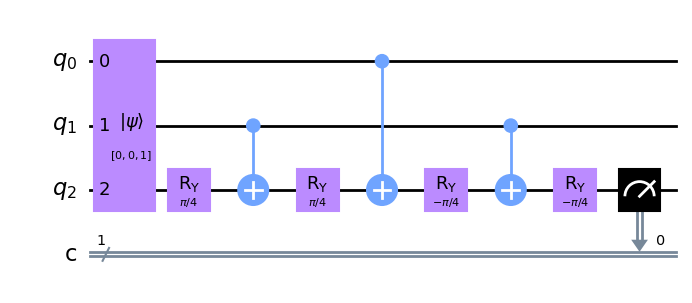

In [4]:
def Margolus(x=0, y=0, z=0):
    circuit = qk.QuantumCircuit(3, 1)
    circuit.initialize(f"{x}{y}{z}")
    circuit.ry(pi/4, 2)
    circuit.cx(1, 2)
    circuit.ry(pi/4, 2)
    circuit.cx(0, 2)
    circuit.ry(-pi/4, 2)
    circuit.cx(1, 2)
    circuit.ry(-pi/4, 2)
    circuit.measure(2, 0)
    return circuit

example = Margolus(z=1)
Margolus = run_circuit(Margolus)
example.draw(output="mpl", style="clifford")

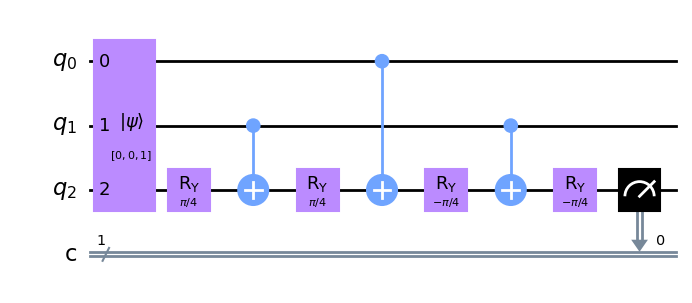

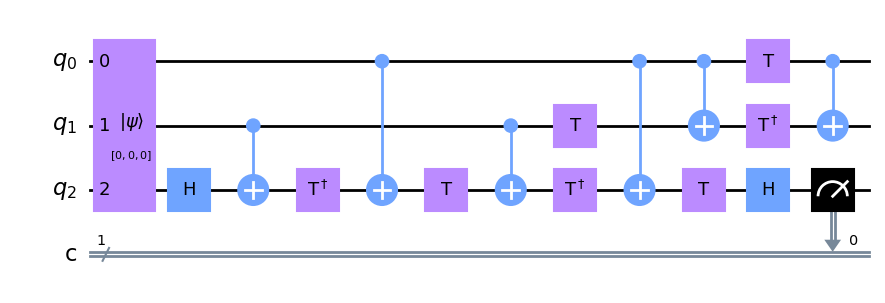

In [5]:
def Toffoli(x=0, y=0, z=0):
    circuit = qk.QuantumCircuit(3, 1)
    circuit.initialize(f"{x}{y}{z}")
    circuit.h(2)
    circuit.cx(1, 2)
    circuit.tdg(2)
    circuit.cx(0, 2)
    circuit.t(2)
    circuit.cx(1, 2)
    circuit.tdg(2)
    circuit.cx(0, 2)
    circuit.t([1, 2])
    circuit.h(2)
    circuit.cx(0, 1)
    circuit.tdg(1)
    circuit.t(0)
    circuit.cx(0, 1)
    circuit.measure(2, 0)
    return circuit

example = Toffoli()
Toffoli = run_circuit(Toffoli)
example.draw(output="mpl", style="clifford")

In [6]:
for x in [0, 1]:
    for y in [0, 1]:
        for z in [0, 1]:
            res_margolus = Margolus(x, y, z).quasi_dists[0].keys()
            res_toffoli = Toffoli(x, y, z).quasi_dists[0].keys()
            print(f"Expected answer for CCX({x},{y},{z}) is", (x & y) ^ z,"\n", 
                  "Margolus:", *res_margolus, "\n", 
                  "Toffoli:", *res_toffoli)

Expected answer for CCX(0,0,0) is 0 
 Margolus: 0 
 Toffoli: 0
Expected answer for CCX(0,0,1) is 1 
 Margolus: 0 
 Toffoli: 0
Expected answer for CCX(0,1,0) is 0 
 Margolus: 0 
 Toffoli: 0
Expected answer for CCX(0,1,1) is 1 
 Margolus: 1 
 Toffoli: 1
Expected answer for CCX(1,0,0) is 0 
 Margolus: 1 
 Toffoli: 1
Expected answer for CCX(1,0,1) is 1 
 Margolus: 1 
 Toffoli: 1
Expected answer for CCX(1,1,0) is 1 
 Margolus: 1 
 Toffoli: 1
Expected answer for CCX(1,1,1) is 0 
 Margolus: 0 
 Toffoli: 0


# Adder

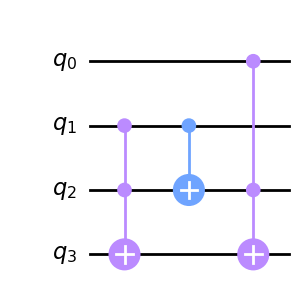

In [7]:
CarryGate = qk.QuantumCircuit(4, name="Carry")
CarryGate.ccx(1, 2, 3)
CarryGate.cx(1, 2)
CarryGate.ccx(0, 2, 3)
CarryGate.draw(output="mpl", style="clifford")

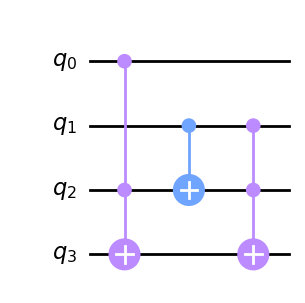

In [8]:
InverseCarryGate = qk.QuantumCircuit(4, name="InverseCarry")
InverseCarryGate.ccx(0, 2, 3)
InverseCarryGate.cx(1, 2)
InverseCarryGate.ccx(1, 2, 3)
InverseCarryGate.draw(output="mpl", style="clifford")

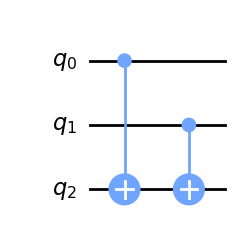

In [9]:
SumGate = qk.QuantumCircuit(3, name="Sum")
SumGate.cx(0, 2)
SumGate.cx(1, 2)
SumGate.draw(output="mpl", style="clifford")

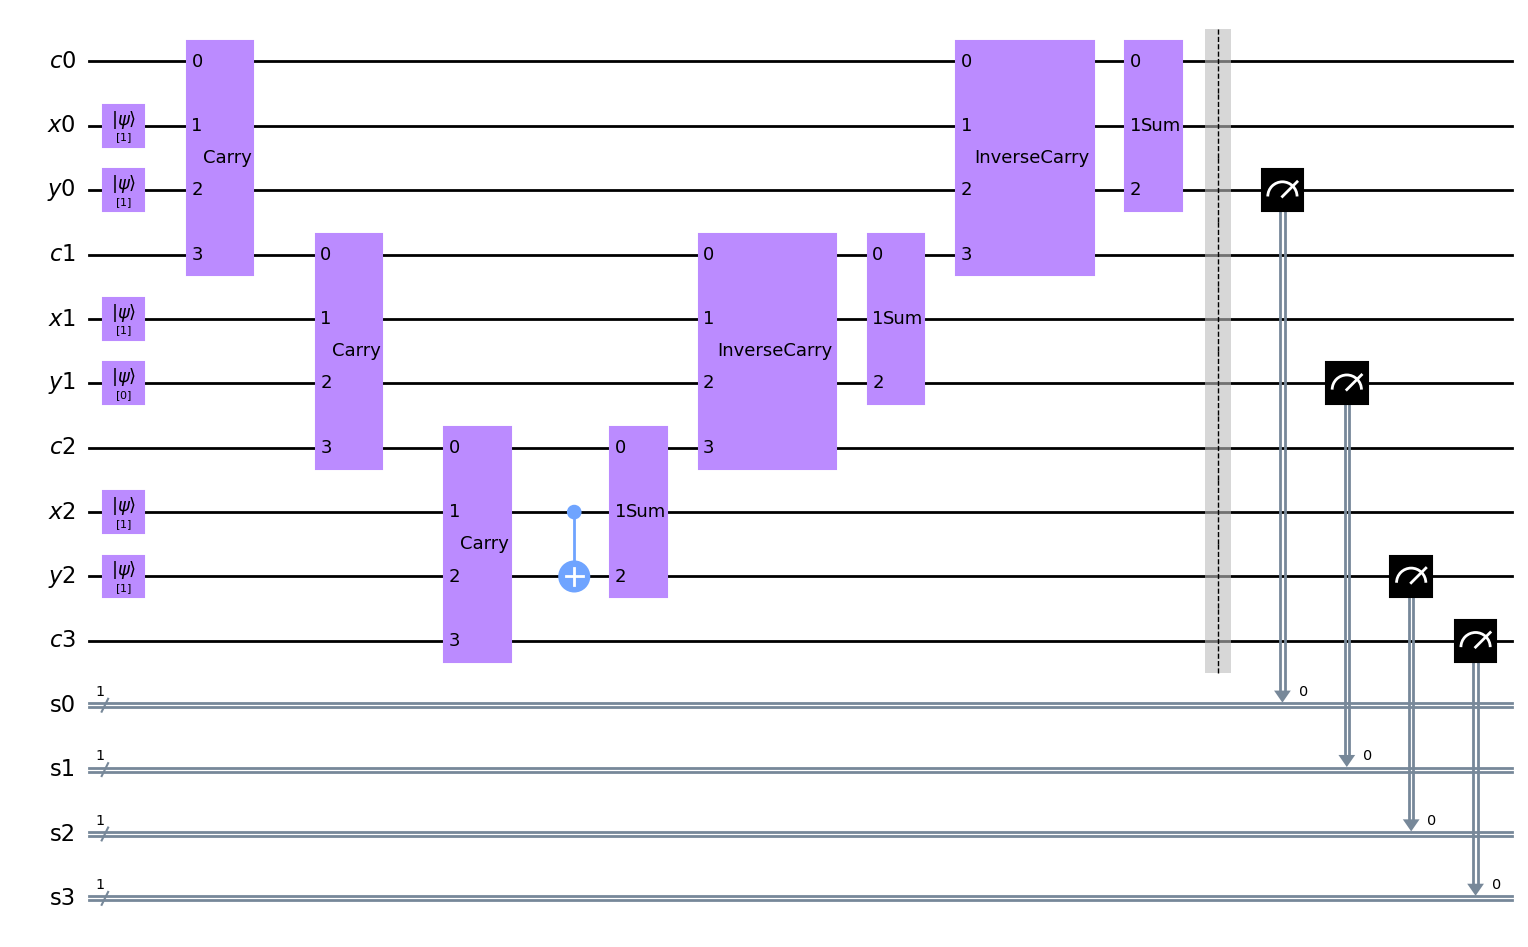

In [56]:
# @run_circuit
def add(x, y):
    '''
    Adder circuit

    Args:
        x (int): First input
        y (int): Second input

    Returns:
        circuit (QuantumCircuit): Adder circuit
    '''

    global CarryGate, InverseCarryGate, SumGate
    assert 0 <= x and 0 <= y, "Invalid input"
    # Preprocessing
    x_str, y_str = map(lambda x: bin(x)[2:], [x, y])
    max_len = max(len(x_str), len(y_str))
    # Padding
    x_str = "0" * (max_len - len(x_str)) + x_str
    y_str = "0" * (max_len - len(y_str)) + y_str

    # Initializing carry bits
    carry_bits = []
    for i in range(max_len + 1):
        carry_bits.append(qk.QuantumRegister(1, name="c" + str(i)))
    
    # Initializing numbers
    x = [qk.QuantumRegister(1, name="x" + str(i)) for i in range(max_len)]
    y = [qk.QuantumRegister(1, name="y" + str(i)) for i in range(max_len)]

    # Initializing output bits
    s = [qk.ClassicalRegister(1, name="s" + str(i)) for i in range(max_len + 1)]

    # Initializing circuit
    init_list = []
    for i in range(max_len):
        init_list.extend([carry_bits[i], x[i], y[i]])
    init_list.append(carry_bits[max_len])
    init_list.extend(s)
    circuit = qk.QuantumCircuit(*init_list)

    # Initializing qbits
    for i in range(max_len):
        circuit.initialize(x_str[i], x[max_len - i - 1])
        circuit.initialize(y_str[i], y[max_len - i - 1])

    # Circuit itself
    for i in range(max_len):
        circuit.append(CarryGate, [carry_bits[i], x[i], y[i], carry_bits[i+1]])

    circuit.cx(x[-1], y[-1])

    circuit.append(SumGate, [carry_bits[-2], x[-1], y[-1]])
    for i in range(max_len - 2, -1, -1):
        circuit.append(InverseCarryGate, [carry_bits[i], x[i], y[i], carry_bits[i+1]])    
        circuit.append(SumGate, [carry_bits[i], x[i], y[i]])
    circuit.barrier()

    # Output
    result_qbits = list(map(lambda x: x[0], y)) + [carry_bits[-1][0]]
    output_bits = map(lambda x: x[0], s)
    circuit.measure(result_qbits, output_bits)
    return circuit

add(7, 5).draw(output="mpl", style="clifford")

In [41]:
run_circuit(add)(12, 34)

SamplerResult(quasi_dists=[{46: 1.0}], metadata=[{}])

In [38]:
test = [(x + y) == list(add(x, y).quasi_dists[0].keys())[0] for x in range(15) for y in range(15)]
all(test)

True

In [34]:
for x in range(15):
    for y in range(15):
        print("Real answer", x + y, "Computed", *add(x, y).quasi_dists[0])

Real answer 0 Computed 0
Real answer 1 Computed 1
Real answer 2 Computed 2
Real answer 3 Computed 3
Real answer 4 Computed 4
Real answer 5 Computed 5
Real answer 6 Computed 6
Real answer 7 Computed 7
Real answer 8 Computed 8
Real answer 9 Computed 9
Real answer 10 Computed 10
Real answer 11 Computed 11
Real answer 12 Computed 12
Real answer 13 Computed 13
Real answer 14 Computed 14
Real answer 1 Computed 1
Real answer 2 Computed 2
Real answer 3 Computed 3
Real answer 4 Computed 4
Real answer 5 Computed 5
Real answer 6 Computed 6
Real answer 7 Computed 7
Real answer 8 Computed 8
Real answer 9 Computed 9
Real answer 10 Computed 10
Real answer 11 Computed 11
Real answer 12 Computed 12
Real answer 13 Computed 13
Real answer 14 Computed 14
Real answer 15 Computed 15
Real answer 2 Computed 2
Real answer 3 Computed 3
Real answer 4 Computed 4
Real answer 5 Computed 5
Real answer 6 Computed 6
Real answer 7 Computed 7
Real answer 8 Computed 8
Real answer 9 Computed 9
Real answer 10 Computed 10
R